#### Import Dependencies

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
import math

#### Calculating RSI
The RSI uses a two-part calculation that starts with the following formula.

The average gain or loss used in this calculation is the average percentage gain or loss during a look-back period. The formula uses a positive value for the average loss. Periods with price losses are counted as zero in the calculations of average gain. Periods with price increases are counted as zero in the calculations of average loss.

The standard number of periods used to calculate the initial RSI value is 14.

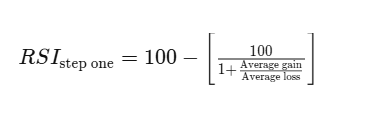

Once there are 14 periods of data available, the second calculation can be done. Its purpose is to smooth the results so that the RSI only nears 100 or zero in a strongly trending market

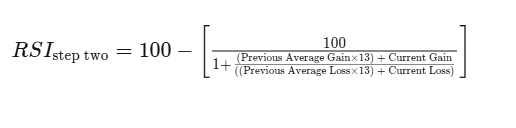

#### Formula

In [ ]:
def RSI(prev_avg_gain, prev_avg_loss, current_gain, current_loss, interval):
    prev_avg_gain = (prev_avg_gain * (interval - 1) + current_gain) / interval
    prev_avg_loss = (prev_avg_loss * (interval - 1) + current_loss) / interval

    if prev_avg_loss == 0:
        rsi = 100
    else:
        rs = prev_avg_gain / prev_avg_loss
        rsi = 100 - (100 / (1 + rs))

    return {
        "rsi": rsi,
        "prev_avg_gain": prev_avg_gain,
        "prev_avg_loss": prev_avg_loss
    }

# intervals are in days|
def avg_gain_or_loss(data: pd.DataFrame, interval: int, loss: bool):
    latest_14_days = data.iloc[1:interval + 1].copy()  # FIX: use rows 1 to 14
    latest_14_days["change"] = latest_14_days["Close"].values - data["Close"].values[0:interval]

    if loss:
        total_loss = latest_14_days["change"].apply(lambda x: -x if x < 0 else 0).sum()
        avg_loss = total_loss / interval
        return avg_loss
    else:
        total_gain = latest_14_days["change"].apply(lambda x: x if x > 0 else 0).sum()
        avg_gain = total_gain / interval
        return avg_gain

#### Get Data Series

In [ ]:
# get spy etf data
appl = yf.Ticker("AAPL")
appl = appl.history(auto_adjust=False)
appl = appl.sort_index(ascending=True)
appl

In [ ]:
import ta
import ta.momentum

# Access the Close price using the MultiIndex

# Calculate RSI using TA-Lib with the proper array
rsi_ta = ta.momentum.RSIIndicator(close=appl["Close"], window=14)
rsi_ta.rsi()

#### RSI

In [ ]:
interval = 14
rsi_values = []
avg_14_gain = avg_gain_or_loss(data=appl,
                                interval=14,
                                loss=False,
                                )

avg_14_loss = avg_gain_or_loss(data=appl,
                                interval=14,
                                loss=True,
                                )

for i in range(interval - 1, len(appl)):
    current_change = appl["Close"].iloc[i] - appl["Close"].iloc[i - 1]
    current_gain = current_change if current_change > 0 else 0
    current_loss = -current_change if current_change < 0 else 0  # FIX: loss must be positive
    
    values = RSI(prev_avg_gain=avg_14_gain,
                    prev_avg_loss=avg_14_loss,
                    current_gain=current_gain,
                    current_loss=current_loss,
                    interval=14)
    
    avg_14_gain = values["prev_avg_gain"]
    avg_14_loss = values["prev_avg_loss"]
    
    rsi_values.append(values["rsi"])

rsi_values

#### Plotting RSI

In [ ]:
from typing import List

def plot_RSI(data: pd.DataFrame, rsi_values):
    date_labels = data.index.strftime("%Y-%m-%d").tolist()

    plt.figure(figsize=(10, 8))
    plt.plot(range(len(rsi_values)), rsi_values, label="RSI")

    plt.xticks(ticks=range(len(rsi_values)), labels=date_labels[-len(rsi_values):], rotation=45)
    plt.ylim(0, 100)
    plt.yticks(range(0, 101, 10))

    plt.title("RSI Indicator")
    plt.xlabel("Date")
    plt.ylabel("RSI Value")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
plot_RSI(data=appl,
         rsi_values=rsi_values)